<a href="https://colab.research.google.com/github/TirendazAcademy/Deep-Learning-with-TensorFlow/blob/main/Transfer-Learning-with-Data-Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Data Loading

In [2]:
dataset, info=tfds.load("tf_flowers", as_supervised=True,
                        with_info= True)

In [3]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/root/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

# Data Preprocessing

In [4]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [5]:
class_names = info.features["label"].names 
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [6]:
n_classes = info.features["label"].num_classes
n_classes

5

In [7]:
test_set_raw,valid_set_raw,train_set_raw=tfds.load(
    "tf_flowers",
    split = ["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True
)

In [8]:
batch_size = 32
preprocess=tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224,
                             crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(
        tf.keras.applications.xception.preprocess_input
    )                         
])

In [9]:
train_set=train_set_raw.map(lambda X,y:(preprocess(X),y))
train_set=train_set.shuffle(1000,seed=42).batch(batch_size).prefetch(1)

valid_set=valid_set_raw.map(lambda X,y:(preprocess(X),y)).batch(batch_size)
test_set=test_set_raw.map(lambda X,y:(preprocess(X),y)).batch(batch_size)

In [10]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42)
])

# Model Building

In [11]:
tf.random.set_seed(42)
base_model=tf.keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False
)

In [12]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
output=tf.keras.layers.Dense(n_classes, activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs=output)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                             

In [14]:
for layer in base_model.layers:
  layer.trainable = False

In [15]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
    metrics=["accuracy"])

# Model Training

In [16]:
history=model.fit(train_set, 
                  validation_data=valid_set,
                  epochs=3)

Epoch 1/3
86/86 [==============================] - 29s 178ms/step - loss: 0.8919 - accuracy: 0.7547 - val_loss: 0.9176 - val_accuracy: 0.8113
Epoch 2/3
86/86 [==============================] - 15s 167ms/step - loss: 0.6715 - accuracy: 0.8339 - val_loss: 0.8160 - val_accuracy: 0.8113
Epoch 3/3
86/86 [==============================] - 16s 169ms/step - loss: 0.6226 - accuracy: 0.8434 - val_loss: 0.9375 - val_accuracy: 0.8203


In [17]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_1                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [18]:
for layer in base_model.layers[56:]:
  layer.trainable = True

In [19]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
    metrics=["accuracy"])

In [20]:
history=model.fit(train_set, 
                  validation_data=valid_set,
                  epochs=10)

Epoch 1/10
86/86 [==============================] - 39s 329ms/step - loss: 0.8001 - accuracy: 0.7344 - val_loss: 3.0512 - val_accuracy: 0.7060
Epoch 2/10
86/86 [==============================] - 28s 320ms/step - loss: 0.4333 - accuracy: 0.8586 - val_loss: 1.8520 - val_accuracy: 0.7296
Epoch 3/10
86/86 [==============================] - 28s 315ms/step - loss: 0.3361 - accuracy: 0.8863 - val_loss: 0.5930 - val_accuracy: 0.8004
Epoch 4/10
86/86 [==============================] - 28s 318ms/step - loss: 0.2395 - accuracy: 0.9121 - val_loss: 0.4589 - val_accuracy: 0.8784
Epoch 5/10
86/86 [==============================] - 29s 328ms/step - loss: 0.2072 - accuracy: 0.9357 - val_loss: 0.3991 - val_accuracy: 0.8893
Epoch 6/10
86/86 [==============================] - 28s 311ms/step - loss: 0.1480 - accuracy: 0.9553 - val_loss: 0.4327 - val_accuracy: 0.8838
Epoch 7/10
86/86 [==============================] - 28s 317ms/step - loss: 0.1244 - accuracy: 0.9593 - val_loss: 0.6427 - val_accuracy: 0.8258

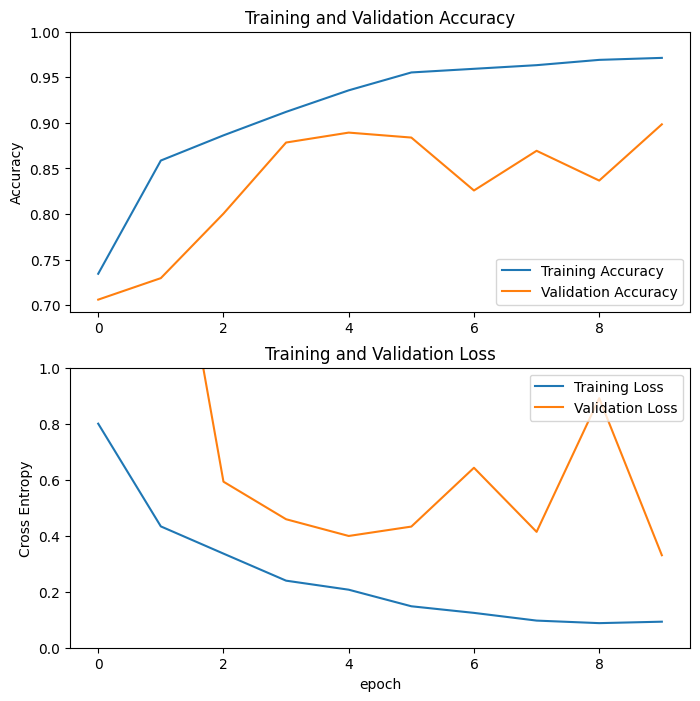

In [21]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##Resource:
- [Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/)

[YouTube](https://www.youtube.com/c/TirendazAcademy) | [Medium](https://tirendazacademy.medium.com) | [Twitter](https://twitter.com/TirendazAcademy) | [Instagram](https://www.instagram.com/tirendazacademy) | [GitHub](https://github.com/TirendazAcademy) | [LinkedIn](https://www.linkedin.com/in/tirendaz-academy)